# Task description

A simple model of forest fire may be defined as a two-dimensional cellural automation on a grid of cells, which take one of three states: empty, occupied by a tree or burning. The automaton evolves according to the following rules, which are executed simultaneously for every cell at a given generation:
1. A burning cell turns into an empty cell.
2. A cell occupied by a tree becomes a burning cell, if any of its eight neigboring cells are burning.

Implement the model in Python on a $L \times L$ square lattice. At the beginning of the simulation, every cell of the grid should be populated by a tree with probability $p$. Assume that initially all trees at one of the edges are burning.
1. Find the so called percolation threshold $p^\star$, i.e. the probability that fire hist the opposite edge of the grid during the simulation. Use $L = 20$, $50$ and $100$ for the linear size of the lattice.
2. Plot the average size of the biggest cluster of burned trees as function of $p$ for $L = 100$. Use the [Hoshen-Kopelman algorithm](https://en.wikipedia.org/wiki/Hoshen%E2%80%93Kopelman_algorithm) for cluster detection.
3. (Optional) Propose a method to add wind to the model. Check how the results change with different wind directions and strengths.

# Solution

Before anything else we import all the necessary libraries and set up global settings:

In [1]:
%matplotlib inline

In [73]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML
import matplotlib
from tqdm.notebook import tqdm

In [67]:
matplotlib.rcParams['figure.figsize'] = [10, 10]
matplotlib.rc('font', family='Lato', size=16)

To make the code more readable and more error-prone we we will define codes for different states of the cells:

In [4]:
BURNING = -2
BURNED = -1
EMPTY = 0
TREE = 1

Then come the field parameters

In [5]:
TREE_PROBABILITY = 0.5
WIDTH = 50
HEIGHT = 50

And a custom exception

In [6]:
class InvalidArgumentException(Exception):
    pass

To represent the field at timestep we will create a class `Field` which, in essence, is a wrapper around simple matrix with additional method for checking if the field is burning, getting state of neighbours of specific cell or generating pleasant looking image.

In [44]:
class Field:
    def __init__(self, matrix):
        self.matrix = matrix
        self.nrows = self.matrix.shape[0]
        self.ncols = self.matrix.shape[1]
    
    def __getitem__(self, index):
        return self.matrix[index]
    
    def __setitem__(self, index, value):
        self.matrix[index] = value
        
    def __eq__(self, value):
        return self.matrix == value
    
    @staticmethod
    def random(shape, tree_probability=0.5):
        return Field(np.random.choice([EMPTY, TREE], size=shape, 
                                      p=[1 - tree_probability, tree_probability]))
    
    def copy(self):
        return Field(self.matrix.copy())
    
    def set_burning(self, side):
        if side == 'top':
            self.matrix[0, :][self.matrix[0, :] == TREE] = BURNING
        elif side == 'right':
            self.matrix[:, -1][self.matrix[:, -1] == TREE] = BURNING
        elif side == 'bottom':
            self.matrix[-1, :][self.matrix[-1, :] == TREE] = BURNING
        elif side == 'left':
            self.matrix[:, 0][self.matrix[:, 0] == TREE] = BURNING
        else:
            raise InvalidArgumentException(f"Invalid side \"{side}\".")
    
    def is_burning(self, side=None):
        return self._is_specific_state(BURNING, side)
    
    def is_burned(self, side=None):
        return self._is_specific_state(BURNED, side)
    
    def _is_specific_state(self, state, side=None):
        if side == 'top':
            return np.any(self.matrix[0, :] == state)
        elif side == 'right':
            return np.any(self.matrix[:, -1] == state)
        elif side == 'bottom':
            return np.any(self.matrix[-1, :] == state)
        elif side == 'left':
            return np.any(self.matrix[:, 0] == state)
        elif side is None:
            return np.any(self.matrix == state)
        else:
            raise InvalidArgumentException(f"Invalid side \"{side}\".")
        
    def neighbours_of(self, x, y, window=(1, 1, 1, 1), type="moore"):
        copy = self.matrix.copy()
        center_label = copy.max() + 1  # Marking center for later filtering
        copy[x, y] = center_label
        if type == "moore":
            box = copy[max(0, x - window[3]) : min(self.ncols,  x + window[1] + 1), 
                       max(0, y - window[0]) : min(self.nrows, y + window[2] + 1)]
        elif type == "neumann":
            box = np.array([
                copy[x - window[0], y] if x - window[0] >= 0 else np.NaN,
                copy[x, y - window[3]] if y - window[3] >= 0 else np.NaN,
                copy[x, y + window[1]] if y + window[1] < self.ncols else np.NaN,
                copy[x + window[2], y] if x + window[2] < self.nrows else np.NaN
            ])
            box = box[~np.isnan(box)].astype(np.int)  # Project to int as np.NaN is considered to be a float and consistency
            # with other case would be broken
        else:
            raise InvalidArgumentException(f"Invalid type \"{type}\". Possible types: \"moore\", \"neumann\".")
        return box[box != center_label]
    
    def display(self):
        fig, ax = plt.subplots()
        ax.matshow(self.matrix, 
                   interpolation="nearest", 
                   aspect="equal", 
                   vmin=-2, 
                   vmax=1,
                   extent=[0, self.ncols, 0, self.nrows]
                  )
        ax.set_xticks(np.arange(self.ncols), minor='true')
        ax.set_yticks(np.arange(self.nrows), minor='true')
        plt.grid(alpha=1, color='white', which='minor')

To see the results we generate small field and display it:

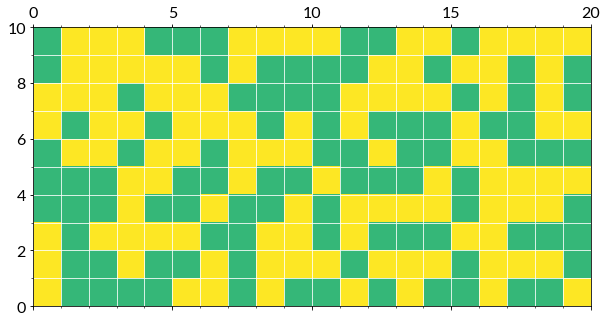

In [69]:
field = Field.random((10, 20), 0.5)
field.display()

And we light trees on left side of the field

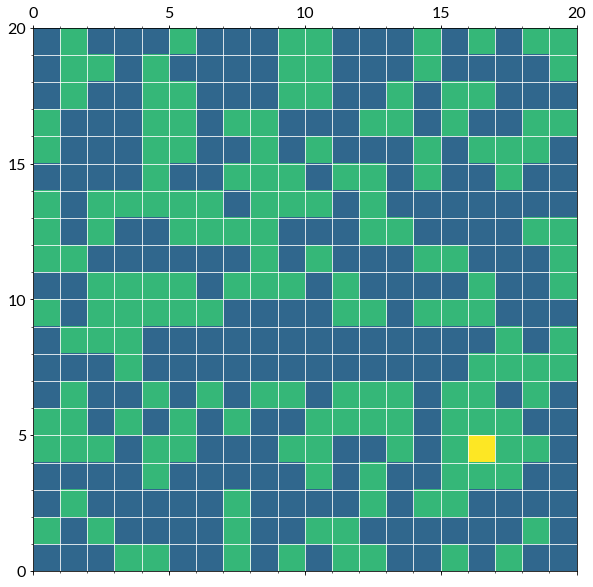

In [68]:
field.set_burning('left')
field.display()

To update the field we define `update_field` function which will return a new field with fire after spreading after one timestep.

In [21]:
def update_field(field):
    copy = field.copy()
    for (x, y), state in np.ndenumerate(field.matrix):
        if state == TREE and np.any(field.neighbours_of(x, y) == BURNING):
            copy[x, y] = BURNING
        if state == BURNING:
            copy[x, y] = BURNED
    return copy

Let's see if it works

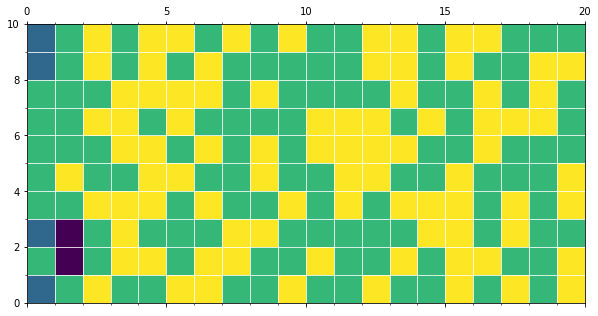

In [22]:
field = update_field(field)
field.display()

Great!

# Clusters

To detect cluster in field we will implement the [Hoshen-Kopelman algorithm](https://en.wikipedia.org/wiki/Hoshen-Kopelman_algorithm).

In the algorithm we have to keep track of so-called equivalence classes, which describe which labels should be later connected into single cluster. To do it we implement additional data structure called `EquivalenceClasses`, which will support single method:
- `add(*values)` - add given values. If any of provided values is present in existing class, then the values are added there, otherwise new class is created.

The class support also the `in` operator (via the `__contains__` method), which returns true if given value is present in any of the classes.

In [24]:
class EquivalenceClasses:
    def __init__(self):
        self.classes = []
    def add(self, *values):
        matching_classes = [c for c in self.classes 
                            if any(value in c for value in values )]
        new_list = {*values}
        for _class in matching_classes:
            new_list.update(_class)
            self.classes.remove(_class)
        self.classes.append(new_list)
    def __contains__(self, value):
        return any(value in _class for _class in self.classes)
    def __repr__(self):
        return self.classes.__repr__()

Basic usage is ilustrated below:

In [25]:
eq = EquivalenceClasses()
eq.add(1, 2)
eq.add(3, 4, 5)
eq

[{1, 2}, {3, 4, 5}]

In [26]:
eq.add(5, 6)
eq

[{1, 2}, {3, 4, 5, 6}]

In [28]:
eq.add(1, 5)
eq

[{1, 2, 3, 4, 5, 6}]

We now implement the cluster detection algorithm:

In [29]:
def clusters(field: Field, occupied: int = TREE) -> np.ndarray:
    cluster = np.zeros_like(field.matrix) - 100
    label = 1  # Initial label
    equivalence_classes = EquivalenceClasses()
    for (x, y), state in np.ndenumerate(field.matrix):
        left = field[x - 1, y] if x - 1 >= 0 else None
        top = field[x, y - 1] if y - 1 >= 0 else None
        left_label = cluster[x - 1, y] if x - 1 >= 0 else None
        top_label = cluster[x, y - 1] if y - 1 >= 0 else None
        if state == occupied:
            if left == occupied and top == occupied:
                if left_label == top_label:
                    cluster[x, y] = left_label  # It doesn't matter which one, the labels are the same
                elif left_label != top_label:
                    cluster[x, y] = left_label
                    equivalence_classes.add(left_label, top_label)  # We join the labels in equivalence class
            elif left == occupied and top != occupied:
                cluster[x, y] = left_label
            elif left != occupied and top == occupied:
                cluster[x, y] = top_label
            else:
                cluster[x, y] = label
                label += 1
    # Reducing the equivalence classes
    for cls in equivalence_classes.classes:
        _min = min(cls)
        for val in cls - {_min}:
            cluster[cluster == val] = _min
    return cluster

To make the classes more visible we define little helper function for displaying resulting matrix.

In [30]:
def display_clusters(matrix, *kwargs):
    plt.matshow(matrix, *kwargs)
    for (x, y), value in np.ndenumerate(c):
        if value > 0:
            plt.text(y, x, value, va='center', ha='center')

Result of the cluster detection algorithm for example field can be seen below:

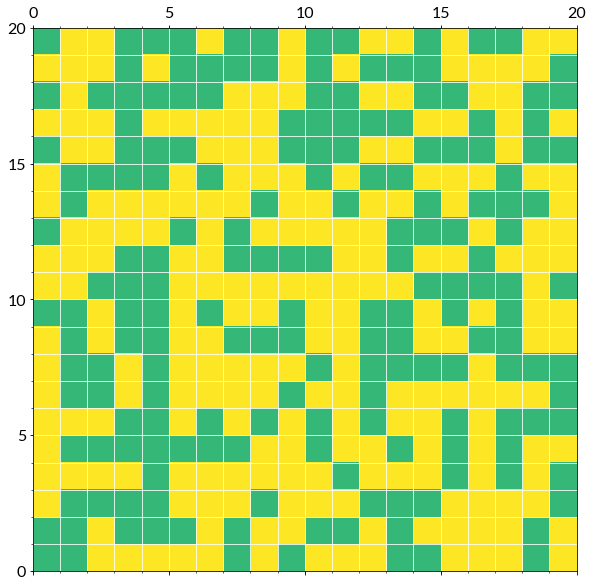

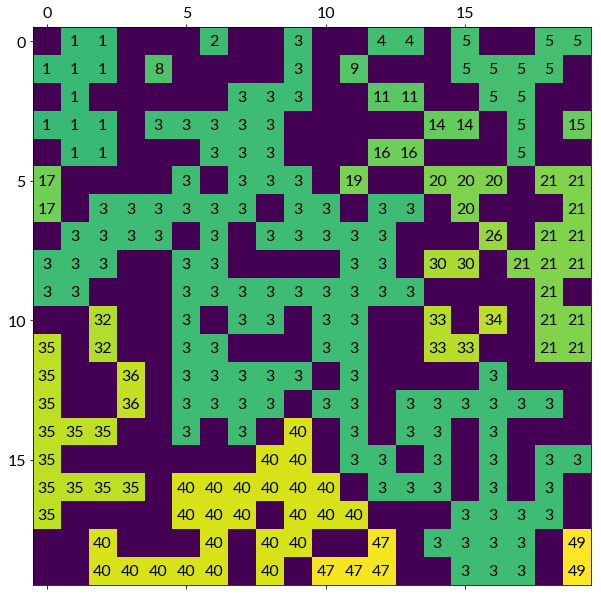

In [70]:
field = Field.random((20, 20), 0.5)
field.display()
c = clusters(field)
display_clusters(c)

We can then check the size of biggest cluster (remebering that background has negative label, so we have to filter that out).

In [33]:
_, counts = np.unique(c[c>0], return_counts=True)
max(counts)

47

## Percolation threshold

To find the percolation threshold as a function of $p$ (probability of tree occupying each cell) we define range for the probabilities and then for each we will run $N=100$ simulations of forest-fire and average the results.

In [63]:
N = 100

In [64]:
probabilities = np.arange(0.2, 0.6, 0.025)

In [65]:
percolation = []
for p in probabilities:
    reached_end = []
    for i in range(N):
        field = Field.random((20, 20), tree_probability=p)
        field.set_burning(side='left')
        while field.is_burning():
            field = update_field(field)
        if field.is_burned(side='right'):
            reached_end.append(True)
        else:
            reached_end.append(False)
    percolation.append(np.mean(reached_end))

We can then plot the results:

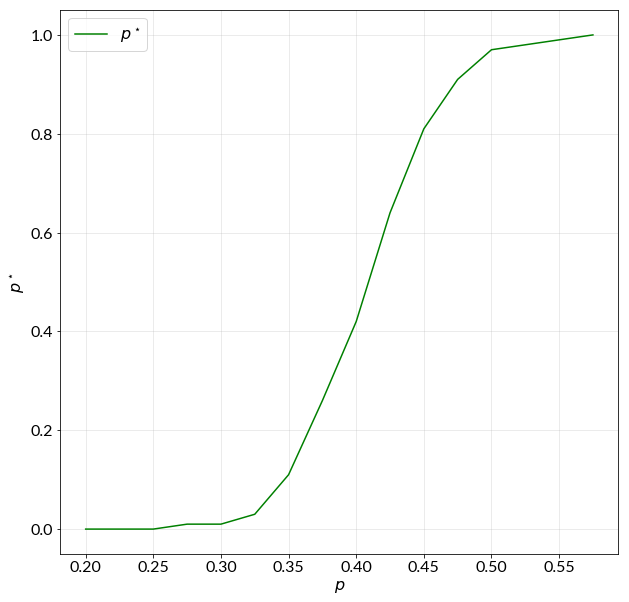

In [71]:
plt.plot(probabilities, percolation, color='g',
         label='$p^\star$')
plt.grid(alpha=0.3)
plt.xlabel('$p$')
plt.ylabel('$p^\star$')
plt.legend()
plt.show()

To find the average size of the biggest cluster of burned trees we will proceed similarly

In [78]:
avg_biggest_cluster = []
for p in tqdm(probabilities):
    biggest_clusters = []
    for i in range(10):
        field = Field.random((100, 100), tree_probability=p)
        field.set_burning(side='left')
        while field.is_burning():
            field = update_field(field)
        c = clusters(field, occupied=BURNED)
        _, count = np.unique(c[c > 0], return_counts=True)
        biggest_clusters.append(np.max(count))
    avg_biggest_cluster.append(np.mean(biggest_clusters))
    

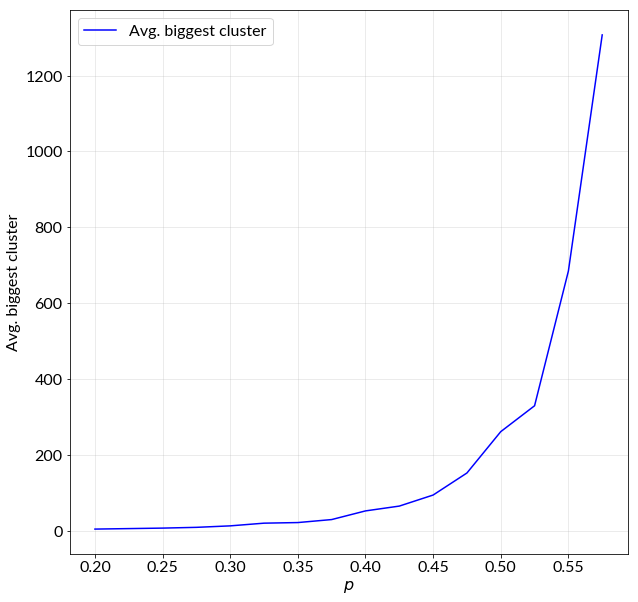

In [81]:
plt.plot(probabilities, avg_biggest_cluster, color='b',
         label='Avg. biggest cluster')
plt.grid(alpha=0.3)
plt.xlabel('$p$')
plt.ylabel('Avg. biggest cluster')
plt.legend()
plt.show()

# Different wind in the model

To add wind to the model we can simply update the `update_field` function and define a new window for checking burning tree neighbours. What that means is that we assume that for a wind strong enough tree's could catch fire from cells at distance more than 1.

We will add `window` as an additional argument.

In [169]:
def update_field(field, window):
    copy = field.copy()
    for (x, y), state in np.ndenumerate(field.matrix):
        if state == TREE and np.any(field.neighbours_of(x, y, window) == BURNING):
            copy[x, y] = BURNING
        if state == BURNING:
            copy[x, y] = BURNED
    return copy

For example if we imagine very strong wind blowing from the west only the cells on the right (even 2 squares apart) could be set ablaze.

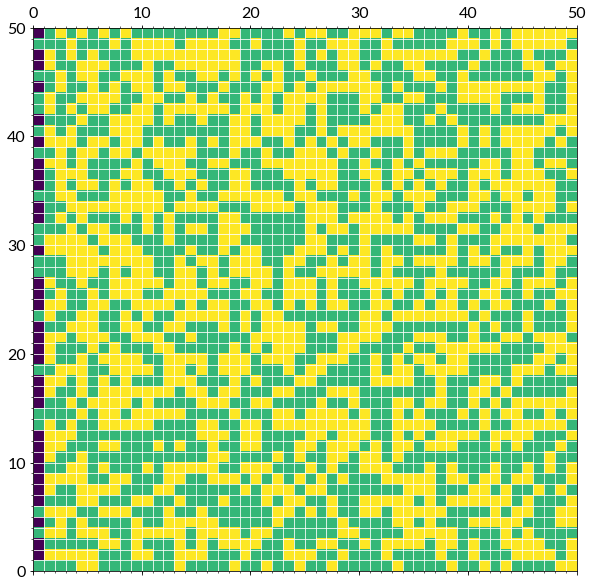

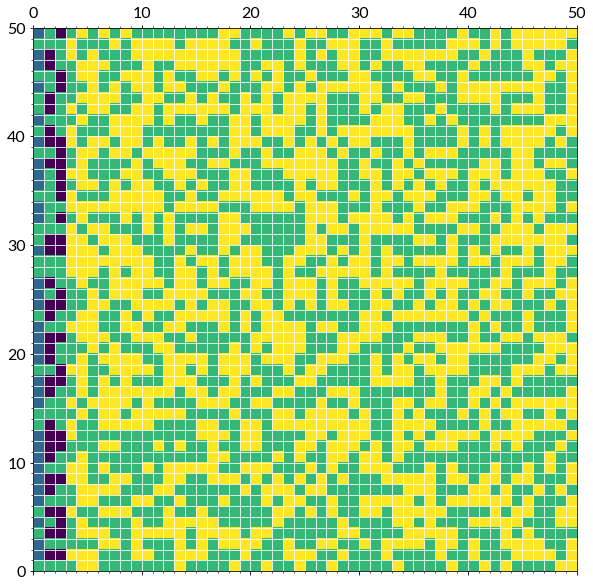

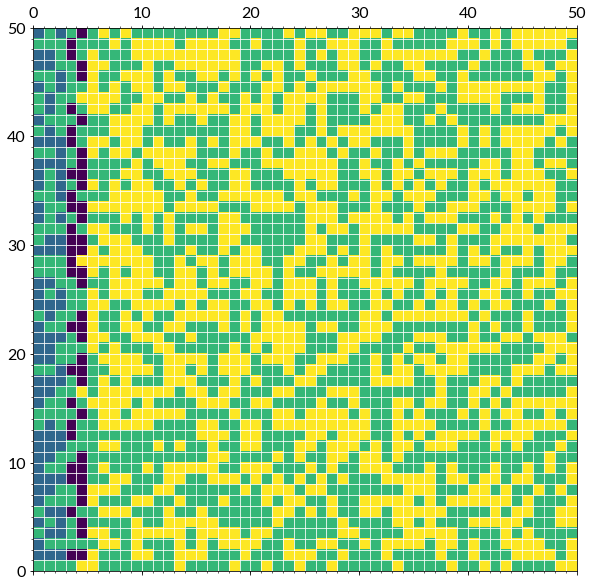

In [183]:
field = Field.random((50, 50))
field.set_burning(side='left')
field.display()
field = update_field(field, window=(2, 2, 2, 0))
field.display()
field = update_field(field, window=(2, 2, 2, 0))
field.display()

# Animation

To creat an animation we will store each frame in a list and later combine those frames into a javascript widget or an wideo.

In [157]:
frames = []

We then create a new filed, ignite it and add the matrix to the frames

In [158]:
field = Field.random((50, 50))
field.set_burning(side='left')
frames.append(field.matrix)

Now we run the simulation capturing the field's matrix add each iteration and appending it to the frames.

In [160]:
while field.is_burning():
    field = update_field(field)
    frames.append(field.matrix)

We now have to predefine an matplotlib's `image` object, which we will be updating with each frame.

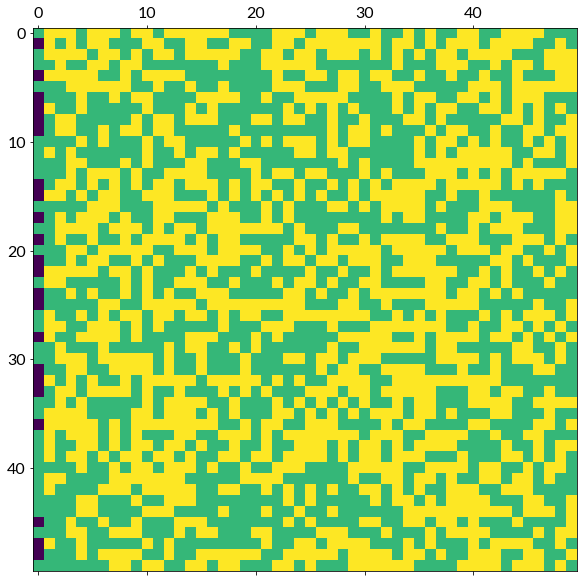

In [161]:
fig, ax = plt.subplots()
image = ax.matshow(frames[0])

We also have to define an `update` function, which will be called by the animation.

In [165]:
frame_counter = 0
def update(frame):
    global frame_counter
    image.set_array(frames[frame_counter])
    frame_counter += 1
    frame_counter = frame_counter % len(frames)

And now we simply run the animation and convert it to a javascipt widget.

In [166]:
anim = animation.FuncAnimation(fig, update, frames=len(frames), 
                               interval=250, repeat_delay=1000)

In [167]:
HTML(anim.to_jshtml())

# Custom colormap

In [ ]:
np.unique(c)

In [ ]:
import matplotlib.cm as cm
import matplotlib.colors

In [ ]:
viridis = cm.get_cmap('viridis')

In [ ]:
new_colors = viridis(np.linspace(c.min(), 1, len(np.unique(c))))
new_colors[0, 2] = 0.0
    
newcmp = matplotlib.colors.ListedColormap(new_colors)

In [ ]:
plt.imshow(c)